In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Paths

In [4]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# Set number of classes

In [5]:
NUM_CLASSES = 4

# Reading the DataSet

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model Building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  
# tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 1,092
Trainable params: 1,092
Non-trainable params: 0
_________________________________________________________________


In [11]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# Model Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/19 [>.............................] - ETA: 13s - loss: 0.7223 - accuracy: 0.6016
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
19/19 [==============================] - 1s 17ms/step - loss: 0.7164 - accuracy: 0.5659 - val_loss: 0.6206 - val_accuracy: 0.6447
Epoch 2/1000
 1/19 [>.............................] - ETA: 0s - loss: 0.6920 - accuracy: 0.5938
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
19/19 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6155 - val_loss: 0.6022 - val_accuracy: 0.7946
Epoch 3/1000
 1/19 [>.............................] - ETA: 0s - loss: 0.6541 - accuracy: 0.6484
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
19/19 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6539 - val_loss: 0.5801 - val_accuracy: 0.7855
Epoch 4/1000
 1/19 [>.............................] - ETA: 0s - loss: 0.6249 - accuracy: 0.6406

In [14]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

7/7 [==============================] - 0s 1ms/step - loss: 0.0676 - accuracy: 0.9884


In [15]:
# Loading the model
model = tf.keras.models.load_model(model_save_path)

In [16]:
# Prediction
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 82ms/step
[0.03787082 0.9621292 ]
1


# Confusion Matrix

25/25 [==============================] - 0s 958us/step


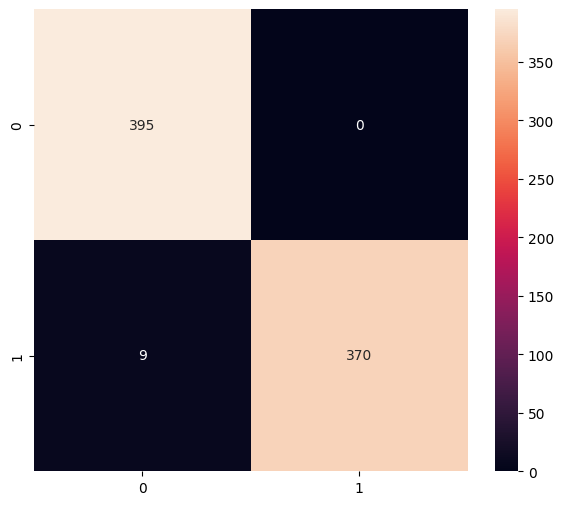

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       395
           1       1.00      0.98      0.99       379

    accuracy                           0.99       774
   macro avg       0.99      0.99      0.99       774
weighted avg       0.99      0.99      0.99       774



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [18]:
# Save the model
model.save(model_save_path, include_optimizer=False)

In [19]:
# Transform the model to tflite
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Dhanuja\AppData\Local\Temp\tmpm820et0y\assets


INFO:tensorflow:Assets written to: C:\Users\Dhanuja\AppData\Local\Temp\tmpm820et0y\assets


6456

# Inference test

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.03787081 0.9621292 ]
1
